In [5]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer
from cluster_helper import ClusterProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv

from collections import Counter

In [2]:
k_neighbors = 50
knn_clusters = 50
keep_k_evecs = 10
drop_k_evecs=2

cluster_assignments = pd.read_csv("./data/CLUSTER_ASSIGNMENTS.csv")
icd9codes = pd.read_csv("../../data/PATIENT_ICD_ICD9_CODES.csv")
patient_icd_binary = pickle.load(open("../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p", 'rb'))
icd9diag = pd.read_csv("../../../mimic/D_ICD_DIAGNOSES.csv.gz")
icd9proc = pd.read_csv("../../../mimic/D_ICD_PROCEDURES.csv.gz")

A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))

In [3]:
cluster_assignments

,SUBJECT_ID,ORIGINAL_INDEX,CLUSTER,MC_CLUSTER
0,109,0,44,9
1,112,1,15,33
2,113,2,17,26
3,114,3,47,15
4,115,4,46,1
...,...,...,...,...
42512,97164,46515,29,1
42513,97484,46516,20,48
42514,97488,46517,22,31
42515,97492,46518,1,10


In [10]:
icd9codes

,ICD9_CODE
0,0030
1,0031
2,0038
3,0039
4,0041
...,...
6979,V902
6980,V9039
6981,V9081
6982,V9089


In [19]:
icd9codes_asarray = icd9codes["ICD9_CODE"].tolist()
len(icd9codes_asarray)

6984

In [35]:
icd9diag

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."
...,...,...,...,...
14562,14432,V7399,Scrn unspcf viral dis,Special screening examination for unspecified ...
14563,14433,V740,Screening for cholera,Screening examination for cholera
14564,14434,V741,Screening-pulmonary TB,Screening examination for pulmonary tuberculosis
14565,14435,V742,Screening for leprosy,Screening examination for leprosy (Hansen's di...


In [6]:
def cluster_size_quartiles(cluster_labels): 
    cluster_label_counts = Counter(cluster_labels).items()
    cluster_labels = [p[0] for p in cluster_label_counts]
    cluster_sizes = [p[1] for p in cluster_label_counts]
    return (np.quantile(cluster_sizes, 0.25), np.quantile(cluster_sizes, 0.75))

y_cluster_quartiles = cluster_size_quartiles(Y_cluster_labels)
y_mc_cluster_quartiles = cluster_size_quartiles(Y_mc_cluster_labels)

print(y_cluster_quartiles, y_mc_cluster_quartiles)

(423.75, 1151.75) (345.5, 1143.5)


In [207]:
#Current scatter plot plots top 3 diseases _ cluster index _ cluster size
#Clusters of interest in order from most to least promising: 
#small = (43, 21, 34)
#medium = (10, 38)
#large = (9, 35)
#NOTE: We want to do a comparison internally across cluster sizes and externally. 
#This means you want to show that small clusters capture diferent things from eachother, repeat with med and lg
#THEN do a comparison across the sizes
#Select the top 10 ICD9 Codes for brevity

def top_cluster_feats(cluster_i, n_top_feats=10):
    #Get features in cluster
    pidx_in_cluster_i = cluster_assignments[cluster_assignments["CLUSTER"] == cluster_i]['ORIGINAL_INDEX']
    pfeats_in_cluster_i = patient_icd_binary[pidx_in_cluster_i]

    #Sum them up to find most common ICD codes
    pfeats_distr_in_cluster_i = np.asarray(pfeats_in_cluster_i.sum(axis=0))

    icd9codes_aslist = icd9codes["ICD9_CODE"].tolist()

    icd_freq_pairs_in_cluster_i = list(zip(icd9codes_aslist, pfeats_distr_in_cluster_i[0]))
    icd_freq_pairs_in_cluster_i = sorted(icd_freq_pairs_in_cluster_i, key=lambda p: p[1], reverse=True)

    #Use only the top n ICD9 codes
    top_icds_freqs_in_cluster_i = icd_freq_pairs_in_cluster_i[:n_top_feats]
    top_icds_in_cluster_i = [p[0] for p in top_icds_freqs_in_cluster_i]
    top_freqs_in_cluster_i = [p[1] for p in top_icds_freqs_in_cluster_i]

    #NOTE total_feats_in_cluster_i is NOT equal to the number of members in a cluster
    sum_top_feats_in_cluster_i = np.sum(top_freqs_in_cluster_i)

    top_icd_percent_occurence_in_cluster_i = [float(f)/sum_top_feats_in_cluster_i for f in top_freqs_in_cluster_i]

    top_icd9_titles = []
    for icd in top_icds_in_cluster_i:
        try:
            long_title = icd9diag[icd9diag['ICD9_CODE'] == icd]["LONG_TITLE"].values[0]
            top_icd9_titles.append(long_title)
        except:
            print("No data found for ICD code {}".format(icd))
            pass

    icd_title_strs_in_cluster_i = ["icd:{}_{}".format(top_icds_in_cluster_i[p], top_icd9_titles[p]) for p in range(n_top_feats)]
    top_feats_in_cluster_i_dict = {"CLUSTER": [cluster_i] * n_top_feats, 
                                   "ICD9_CODE": top_icds_in_cluster_i, 
                                   "ICD9_FREQS": top_freqs_in_cluster_i,
                                   "ICD9_PERCENTAGE": top_icd_percent_occurence_in_cluster_i, 
                                   "LONG_TITLE": top_icd9_titles, 
                                   "ICD_TITLE": icd_title_strs_in_cluster_i}

    top_feats_in_cluster_i_df = pd.DataFrame(top_feats_in_cluster_i_dict)
    return top_feats_in_cluster_i_df

def feats_for_clusters(specific_clusters_of_interest):
    cluster_dfs = []
    for ci in specific_clusters_of_interest:
        ci_df = top_cluster_feats(ci, 5)
        cluster_dfs.append(ci_df)

    cluster_dfs = pd.concat(cluster_dfs)
    unique_icd9codes = pd.unique(cluster_dfs["ICD9_CODE"])
    icd_idx_mapping = {k: v for v, k in enumerate(unique_icd9codes)}
    
    icd_to_icd_title_mapping = {}
    for icd in unique_icd9codes:
        icd_title = cluster_dfs[cluster_dfs["ICD9_CODE"] == icd]["ICD_TITLE"].values[0]
        icd_to_icd_title_mapping[icd] = icd_title
        
    percentage_dfs = []
#     ci = specific_clusters_of_interest[0]
    for ci in specific_clusters_of_interest:
        percentage_vec = np.zeros(len(icd_idx_mapping))

        c_df = cluster_dfs[cluster_dfs["CLUSTER"] == ci]
        c_icds = c_df["ICD9_CODE"].tolist()
        c_percentages = c_df["ICD9_PERCENTAGE"].tolist()

        #Populate the percentage vector with values
        for i, icd in enumerate(c_icds):
            icd_idx = icd_idx_mapping[icd]
            percentage_vec[icd_idx] = c_percentages[i]

        #Use percentage vector to build a dataframe row    
        icd_percentage_pairs = []
        for icd, icd_idx in icd_idx_mapping.items():
            icd_title = icd_to_icd_title_mapping[icd]
            percentage = percentage_vec[icd_idx]
            icd_percentage_pairs.append((icd_title, percentage))
            
        cluster_feat_row = dict(icd_percentage_pairs)
        cluster_feat_row["CLUSTER"] = "C{}".format(ci)
        cluster_percentages_df = pd.DataFrame([cluster_feat_row])
        percentage_dfs.append(cluster_percentages_df)
        
    return pd.concat(percentage_dfs)
   
#Visualize top ICDs => make sure ~5-10 are highly enriched
def heatmap_clusters(cluster_percentage_df, title):
    heatmap_data = cluster_percentage_df.drop("CLUSTER", axis=1).transpose()
    plt.figure(figsize=(5,10))
    g = sns.heatmap(heatmap_data, cmap="Reds", linewidths=2)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
    g.set_xticklabels(cluster_percentage_df['CLUSTER'])
    g.set_title(title, fontsize=15)
    plt.savefig("./heatmaps/heatmap_{}.png".format(title), bbox_inches='tight')

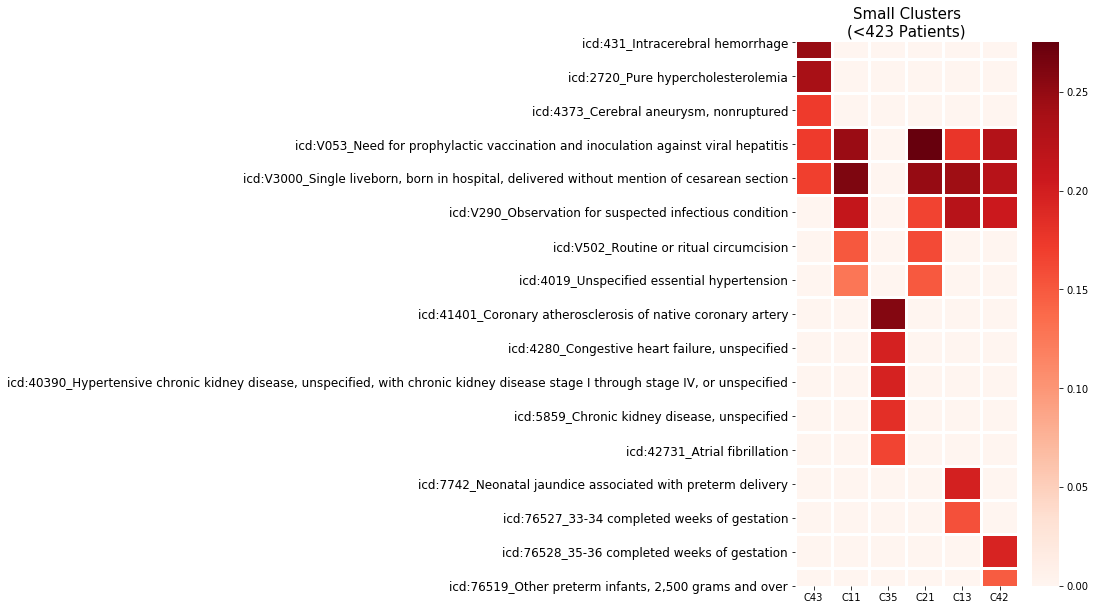

In [208]:
small_clusters = [43, 11, 35, 21, 13, 42]
small_clusters_percentages_df = feats_for_clusters(small_clusters)
heatmap_clusters(small_clusters_percentages_df, title="Small Clusters\n(<423 Patients)")

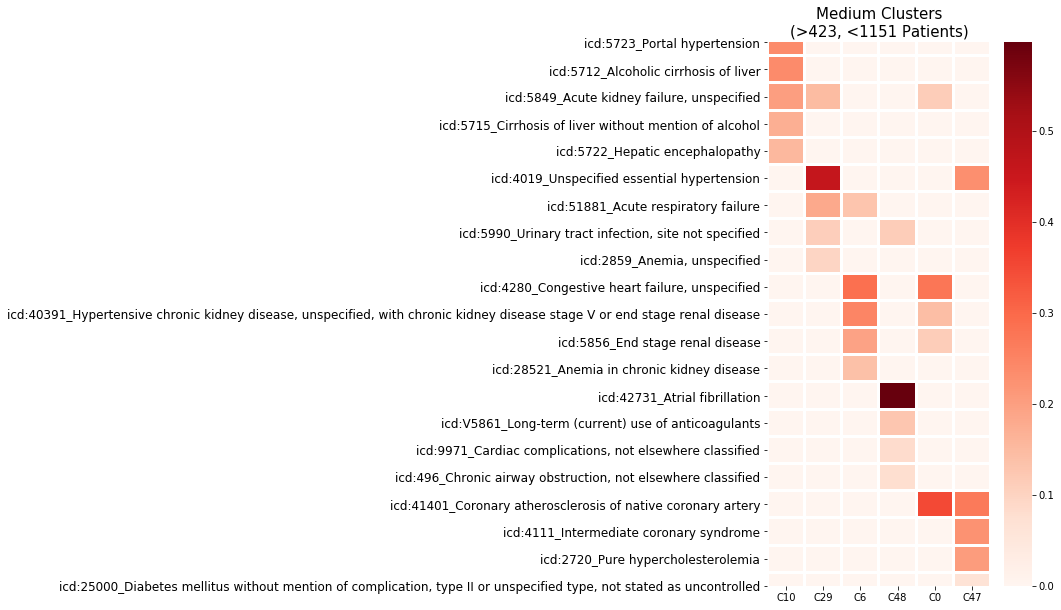

In [209]:
medium_clusters = [10, 29, 6, 48, 0, 47]
medium_clusters_percentages_df = feats_for_clusters(medium_clusters)
heatmap_clusters(medium_clusters_percentages_df, title="Medium Clusters\n(>423, <1151 Patients)")

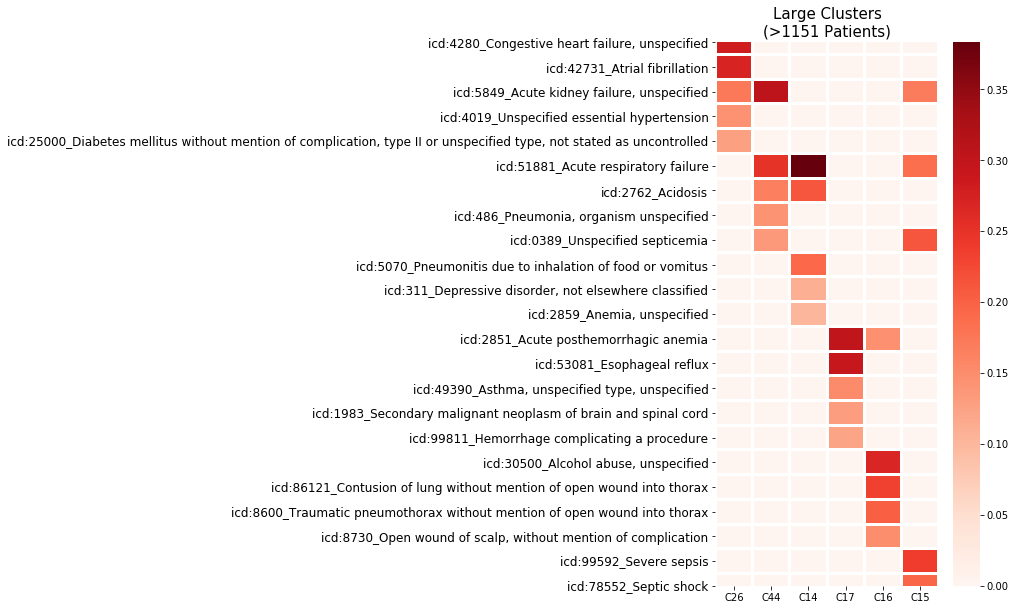

In [214]:
large_clusters = [26, 44, 14, 17, 16, 15]
large_clusters_percentages_df = feats_for_clusters(large_clusters)
heatmap_clusters(large_clusters_percentages_df, title="Large Clusters\n(>1151 Patients)")

In [ ]:
#1. Need to show that clusters make sense -> pheCode or mortality analysis